In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

In [2]:
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [2]:
pip install xgboost

In [7]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.55
test  contamination  0.68 

contamination is 0.55, which is greater than 0.5. Fixing...
contamination is now 0.45


In [4]:
# Example: Undersample anomalies
anomalies = train[train['attack_cat'] != "Normal"]
normal = train[train['attack_cat'] == "Normal"]

# Sample a smaller subset of anomalies to include in the final dataset
undersampled_anomalies = anomalies.sample(frac=0.3, random_state=42)  # Adjust frac as needed
train_undersampled = pd.concat([normal, undersampled_anomalies])


In [5]:
# Example: Oversample normal data points
from sklearn.utils import resample

normal_oversampled = resample(normal, replace=True, n_samples=len(anomalies), random_state=42)
train_oversampled = pd.concat([normal_oversampled, anomalies])


In [ ]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(train.drop('attack_cat', axis=1))

# Identify and remove anomalies
anomaly_scores = iso_forest.decision_function(train.drop('attack_cat', axis=1))
anomalies = anomaly_scores < 0
train_cleaned = train[~anomalies]


In [12]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.utils import resample

# Load the dataset
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Handle missing values and preprocess data (as previously discussed)
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset


# Identify categorical and numeric columns
categorical_cols = ['proto', 'service', 'state']  # Adjust based on actual column names
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()

# Preprocessing: Handle missing values and encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Separate features and target variable
X_train = train.drop('attack_cat', axis=1)
y_train = train['attack_cat']
X_test = test.drop('attack_cat', axis=1)
y_test = test['attack_cat']

# Apply preprocessing to train and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)



In [13]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_preprocessed, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test_preprocessed)


RandomForestClassifier(random_state=42)

In [14]:
# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


                precision    recall  f1-score   support

      Analysis       0.08      0.00      0.01      2000
      Backdoor       1.00      0.02      0.03      1746
           DoS       0.36      0.08      0.13     12264
      Exploits       0.79      0.58      0.67     33393
       Fuzzers       0.47      0.66      0.55     18184
       Generic       0.88      0.98      0.93     40000
        Normal       0.80      1.00      0.89     56000
Reconnaissance       0.94      0.72      0.81     10491
     Shellcode       0.74      0.17      0.28      1133
         Worms       1.00      0.02      0.03       130

      accuracy                           0.77    175341
     macro avg       0.71      0.42      0.43    175341
  weighted avg       0.75      0.77      0.74    175341

[[    7     0    82   414   670   265   561     1     0     0]
 [    3    29   156   400   643   159   344     9     3     0]
 [   26     0   971  2573  4872  1651  2103    48    20     0]
 [   47     0  1162 1936

In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Load the dataset
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')
# Identify categorical and numeric columns
categorical_cols = ['proto', 'service', 'state']  # Adjust based on actual column names
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()

# Preprocessing: Handle missing values and encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Separate features and target variable
X_train = train.drop('attack_cat', axis=1)
y_train = train['attack_cat']
X_test = test.drop('attack_cat', axis=1)
y_test = test['attack_cat']

# Apply preprocessing to train and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Encode target variable (class labels) to numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_preprocessed, y_train_encoded)

# Predict on test data
y_pred = xgb_model.predict(X_test_preprocessed)

# Decode predicted labels to original class labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_decoded))
print(confusion_matrix(y_test, y_pred_decoded))

import joblib

# Save preprocessor and model together (or separately as needed)
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')


                precision    recall  f1-score   support

      Analysis       0.00      0.00      0.00      2000
      Backdoor       0.96      0.05      0.10      1746
           DoS       0.48      0.03      0.06     12264
      Exploits       0.61      0.90      0.73     33393
       Fuzzers       0.78      0.87      0.82     18184
       Generic       0.99      0.98      0.99     40000
        Normal       1.00      1.00      1.00     56000
Reconnaissance       0.92      0.74      0.82     10491
     Shellcode       0.79      0.38      0.52      1133
         Worms       0.70      0.57      0.63       130

      accuracy                           0.86    175341
     macro avg       0.72      0.55      0.57    175341
  weighted avg       0.85      0.86      0.83    175341

[[    0     0     9  1813   177     1     0     0     0     0]
 [    0    92    25  1463   136    10     0    15     3     2]
 [    1     0   388 10414  1270    61     0    97    31     2]
 [    1     1   274 3010

['xgb_model.pkl']

Trying model with 100 estimators...


C:\Users\heart\.conda\envs\ZTM\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:proto, service, state

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 58.7222222222222, 'Predicted')

Text(95.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

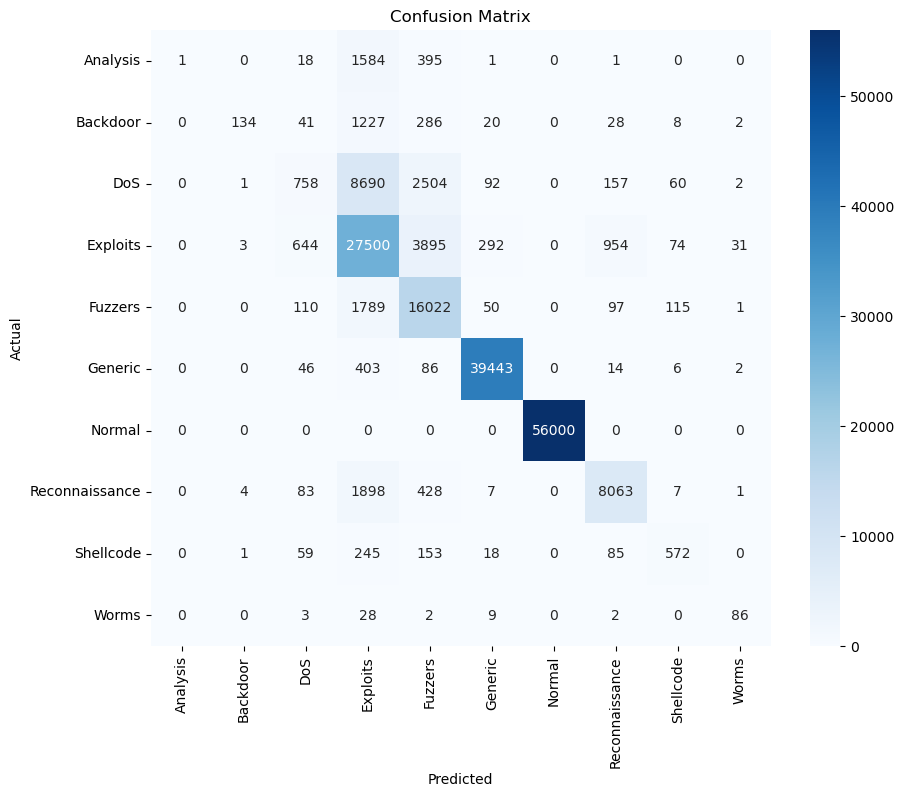

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='None', ylabel='precision'>

<Axes: xlabel='None', ylabel='precision'>

<Axes: xlabel='None', ylabel='precision'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Analysis'),
  Text(1, 0, 'Backdoor'),
  Text(2, 0, 'DoS'),
  Text(3, 0, 'Exploits'),
  Text(4, 0, 'Fuzzers'),
  Text(5, 0, 'Generic'),
  Text(6, 0, 'Normal'),
  Text(7, 0, 'Reconnaissance'),
  Text(8, 0, 'Shellcode'),
  Text(9, 0, 'Worms')])

Text(0.5, 1.0, 'Precision, Recall, and F1-Score by Class')

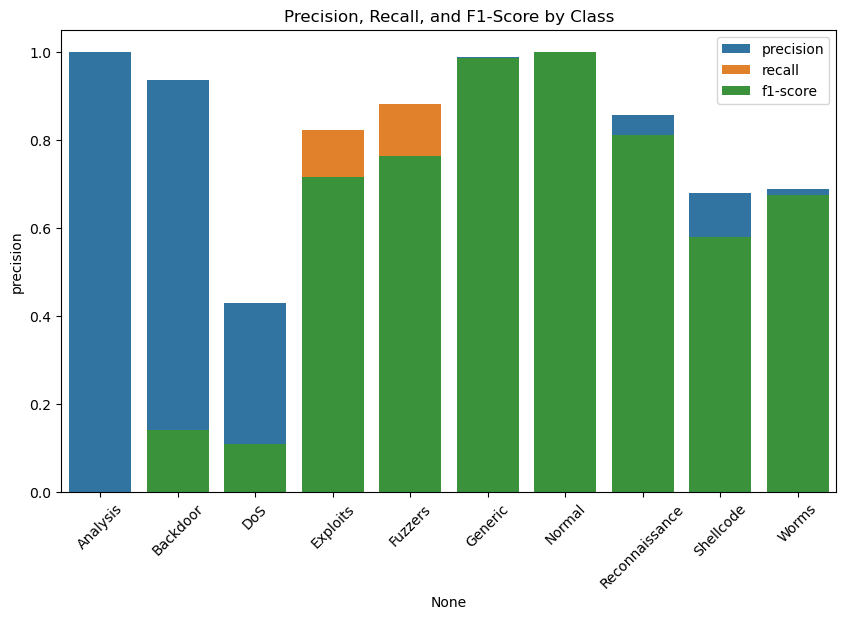

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='attack_cat'>

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Distribution in Test Data')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Analysis'),
  Text(1, 0, 'Backdoor'),
  Text(2, 0, 'DoS'),
  Text(3, 0, 'Exploits'),
  Text(4, 0, 'Fuzzers'),
  Text(5, 0, 'Generic'),
  Text(6, 0, 'Normal'),
  Text(7, 0, 'Reconnaissance'),
  Text(8, 0, 'Shellcode'),
  Text(9, 0, 'Worms')])

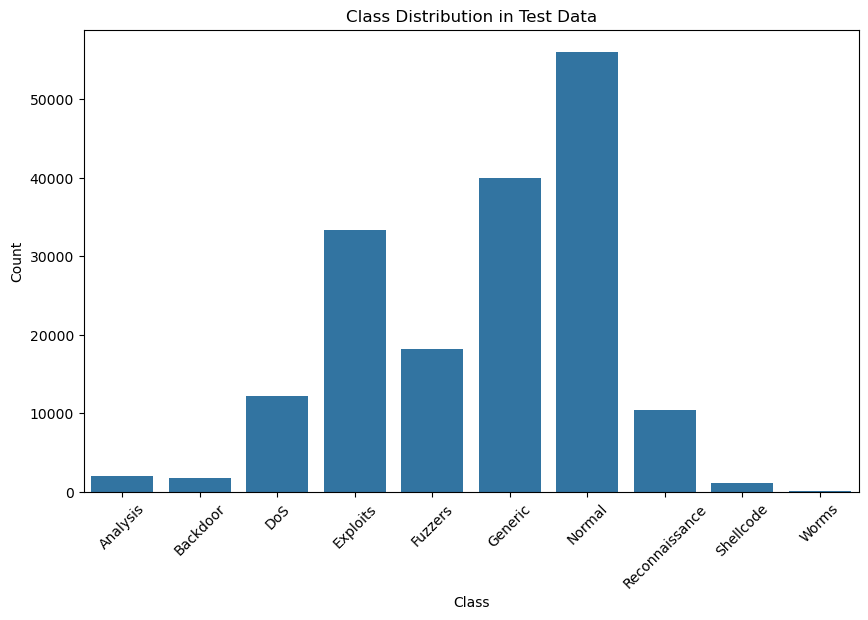

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Define the class names (adjust based on your dataset)
class_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']

# Assume y_test and y_pred_decoded are already available from the previous steps

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_decoded, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_decoded, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Precision, Recall, and F1-Score
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(10, 6))
for metric in metrics:
    sns.barplot(x=report_df.index[:-3], y=report_df[metric][:-3], label=metric)
plt.legend()
plt.xticks(rotation=45)
plt.title('Precision, Recall, and F1-Score by Class')
plt.show()

# Class Distribution
class_counts = pd.Series(y_test).value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Test Data')
plt.xticks(rotation=45)
plt.show()


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 58.7222222222222, 'Predicted')

Text(95.72222222222221, 0.5, 'Actual')

Text(0.5, 1.0, 'Confusion Matrix')

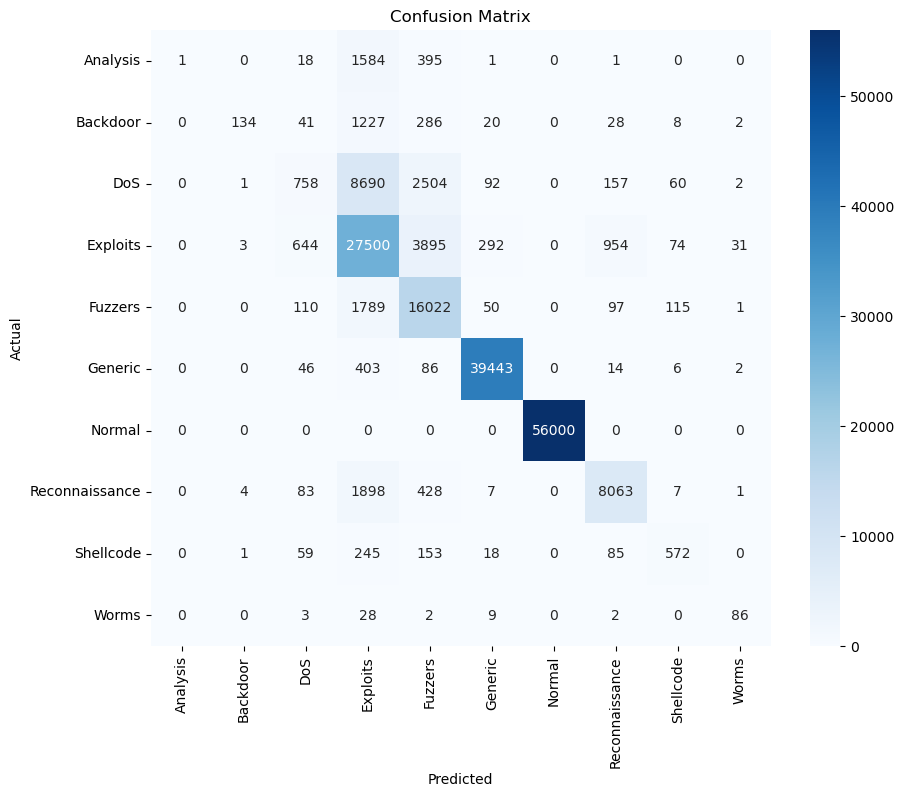

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='None', ylabel='precision'>

<Axes: xlabel='None', ylabel='precision'>

<Axes: xlabel='None', ylabel='precision'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Analysis'),
  Text(1, 0, 'Backdoor'),
  Text(2, 0, 'DoS'),
  Text(3, 0, 'Exploits'),
  Text(4, 0, 'Fuzzers'),
  Text(5, 0, 'Generic'),
  Text(6, 0, 'Normal'),
  Text(7, 0, 'Reconnaissance'),
  Text(8, 0, 'Shellcode'),
  Text(9, 0, 'Worms')])

Text(0.5, 1.0, 'Precision, Recall, and F1-Score by Class')

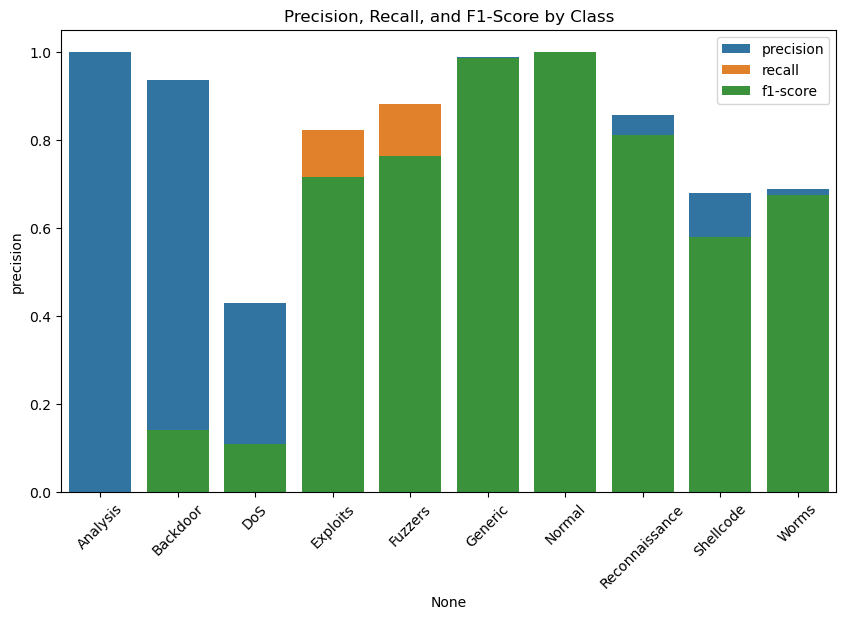

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='attack_cat'>

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Distribution in Test Data')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Analysis'),
  Text(1, 0, 'Backdoor'),
  Text(2, 0, 'DoS'),
  Text(3, 0, 'Exploits'),
  Text(4, 0, 'Fuzzers'),
  Text(5, 0, 'Generic'),
  Text(6, 0, 'Normal'),
  Text(7, 0, 'Reconnaissance'),
  Text(8, 0, 'Shellcode'),
  Text(9, 0, 'Worms')])

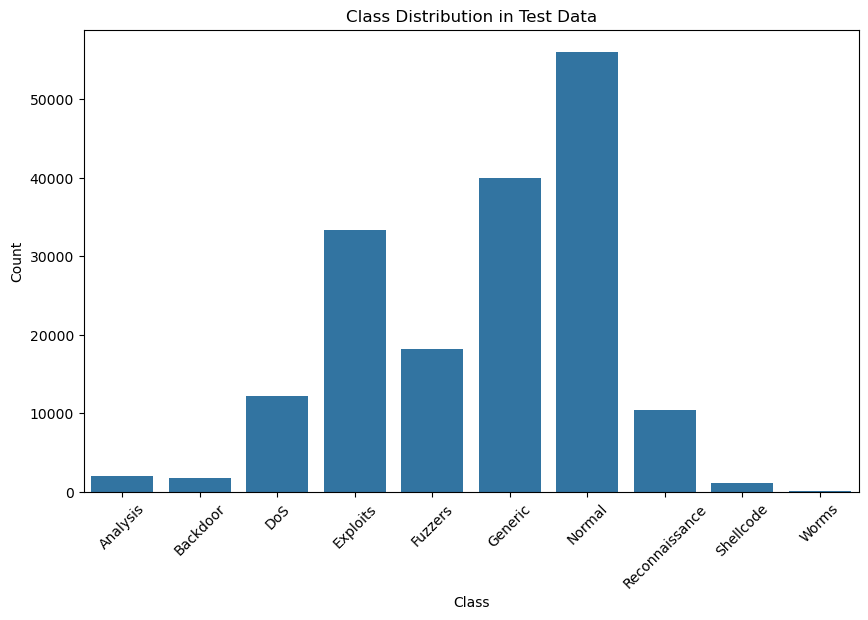

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

# Define the class names (adjust based on your dataset)
class_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Normal', 'Reconnaissance', 'Shellcode', 'Worms']

# Assume y_test and y_pred_decoded are already available from the previous steps

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_decoded, labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')  # Save the confusion matrix
plt.show()

# Classification Report
report = classification_report(y_test, y_pred_decoded, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Save the classification report to a CSV file
report_df.to_csv('classification_report.csv', index=True)

# Precision, Recall, and F1-Score
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(10, 6))
for metric in metrics:
    sns.barplot(x=report_df.index[:-3], y=report_df[metric][:-3], label=metric)
plt.legend()
plt.xticks(rotation=45)
plt.title('Precision, Recall, and F1-Score by Class')
plt.savefig('metrics_by_class.png')  # Save the precision, recall, and f1-score plot
plt.show()

# Class Distribution
class_counts = pd.Series(y_test).value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Test Data')
plt.xticks(rotation=45)
plt.savefig('class_distribution.png')  # Save the class distribution plot
plt.show()


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

# Load the dataset
train = pd.read_csv('UNSW_NB15_training-set.csv')
test = pd.read_csv('UNSW_NB15_testing-set.csv')

# Identify categorical and numeric columns
categorical_cols = ['proto', 'service', 'state']  # Adjust based on actual column names
numeric_cols = train.select_dtypes(include=['number']).columns.tolist()

# Preprocessing: Handle missing values and encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Separate features and target variable
X_train = train.drop('attack_cat', axis=1)
y_train = train['attack_cat']
X_test = test.drop('attack_cat', axis=1)
y_test = test['attack_cat']

# Apply preprocessing to train and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Encode target variable (class labels) to numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Undersample the majority class
# Combine the features and target into a single DataFrame
train_combined = pd.DataFrame(X_train_preprocessed.toarray(), columns=preprocessor.get_feature_names_out())
train_combined['attack_cat'] = y_train_encoded

# Separate majority and minority classes
majority_class = train_combined[train_combined['attack_cat'] == 6]  # Assuming 'Normal' is encoded as 6
minority_classes = train_combined[train_combined['attack_cat'] != 6]

# Adjust sampling size to avoid sampling more than available instances
sampling_size = min(len(minority_classes), len(majority_class))

# Undersample majority class
majority_undersampled = resample(majority_class,
                                 replace=False,  # Sample without replacement
                                 n_samples=sampling_size,  # Adjusted sampling size
                                 random_state=42)  # Reproducible results

# Combine minority class with undersampled majority class
train_undersampled = pd.concat([minority_classes, majority_undersampled])

# Separate features and target variable again
X_train_undersampled = train_undersampled.drop('attack_cat', axis=1)
y_train_undersampled = train_undersampled['attack_cat']

# Train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_undersampled, y_train_undersampled)

# Predict on test data
y_pred = xgb_model.predict(X_test_preprocessed)

# Decode predicted labels to original class labels
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred_decoded))
print(confusion_matrix(y_test, y_pred_decoded))




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

                precision    recall  f1-score   support

      Analysis       0.67      0.00      0.00      2000
      Backdoor       0.85      0.03      0.05      1746
           DoS       0.17      0.36      0.23     12264
      Exploits       0.84      0.30      0.44     33393
       Fuzzers       0.42      0.77      0.54     18184
       Generic       0.95      0.98      0.97     40000
        Normal       1.00      1.00      1.00     56000
Reconnaissance       0.98      0.66      0.79     10491
     Shellcode       0.54      0.07      0.12      1133
         Worms       0.54      0.60      0.57       130

      accuracy                           0.74    175341
     macro avg       0.70      0.48      0.47    175341
  weighted avg       0.83      0.74      0.74    175341

[[    4     0   388   547  1056     2     0     0     3     0]
 [    0    46   614    30  1049     4     0     1     0     2]
 [    1     2  4445   902  6868    22     0     7    15     2]
 [    1     4 14315  991